# Carga y comprobaciones
- Carga cables.csv. Revisa tipos, valores nulos por columna, posibles duplicados y los rangos de las
variables.
- Elimina las columnas redudantes (vacías, valores constantes, índices, etc). 

## Primer paso
- Importaciones
- Leer el csv
- Imprimir por pantalla el tamaño

In [50]:
import pandas as pd
import numpy as np
import warnings, time
from sklearn.impute import SimpleImputer
warnings.filterwarnings("ignore")

#Se define 'df' con los datos de cables.csv
df = pd.read_csv("cables.csv")

#Print para comprobar que se ha cargado
print("Tamaño del dataframe:")
print(df.shape)

Tamaño del dataframe:
(490, 8)


## Segundo paso
- Revisa tipos, valores nulos, etc
- Elimina columnas redundantes

In [51]:
# Número de valores perdidos
nan = df.isna().sum()
print("Hay estos valores que son NaN en cada columna: \n", nan)

#Procedemos a la imputación de valores NaN
imputer = SimpleImputer(strategy="mean")
df[:] = imputer.fit_transform(df)
nan = df.isna().sum()
print("Hay estos valores que son NaN en cada columna: \n", nan)


Hay estos valores que son NaN en cada columna: 
 Unnamed: 0     0
N              5
R             19
S             13
T             16
U              7
G              1
L              0
dtype: int64
Hay estos valores que son NaN en cada columna: 
 Unnamed: 0    0
N             0
R             0
S             0
T             0
U             0
G             0
L             0
dtype: int64


In [52]:
#Revisamos las filas que están duplicadas
dup = df.duplicated().sum()
print("Hay estas filas duplicadas: ", dup)

Hay estas filas duplicadas:  0


In [53]:
#Comprobamos el rango de las variables
df.describe()

,Unnamed: 0,N,R,S,T,U,G,L
count,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000
mean,245.50000,35.053608,499.023312,2239.754717,313.253165,3916.645963,1674.640082,1734.773469
std,141.59508,28.152252,243.979268,6131.757672,315.042665,2214.122349,1169.097879,1155.587275
min,1.00000,1.000000,60.000000,1.000000,3.000000,84.000000,-2103.000000,80.000000
25%,123.25000,16.000000,330.832500,289.000000,108.750000,2013.500000,923.250000,916.500000
50%,245.50000,27.000000,466.670000,729.000000,223.000000,3946.500000,1695.500000,1500.000000
75%,367.75000,45.000000,615.835000,2116.000000,396.250000,5912.750000,2443.000000,2222.750000
max,490.00000,200.000000,1673.330000,102400.000000,2800.000000,7668.000000,4946.000000,7675.000000


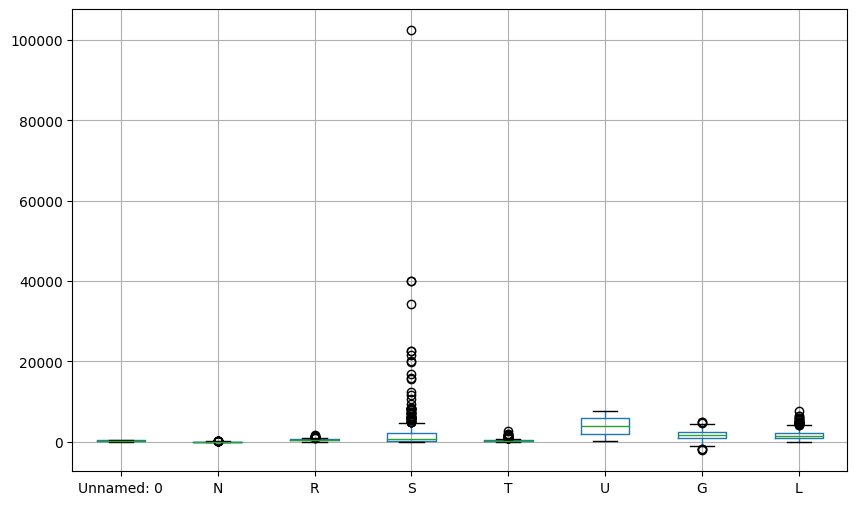

     Unnamed: 0           N            R         S            T       U  \
3             4   76.000000   863.330000    5776.0   745.000000   974.0   
7             8   83.000000   460.000000    6889.0   211.000000  6064.0   
9            10   92.000000   793.330000    8464.0   629.000000  1613.0   
34           35   90.000000   341.670000    8100.0   116.000000  7367.0   
39           40   80.000000  1166.670000    6400.0  1361.000000  6746.0   
41           42  141.000000   966.670000   19881.0   934.000000   183.0   
53           54   79.000000   416.670000    6241.0   173.000000  2891.0   
78           79  108.000000   499.023312   11664.0   374.000000   326.0   
108         109   74.000000   613.330000    5476.0   376.000000  2360.0   
130         131   77.000000   560.000000    5929.0   313.000000  2943.0   
135         136   70.000000   591.670000    4900.0   350.000000  7381.0   
136         137   75.000000   346.670000    5625.0   120.000000  3423.0   
137         138   91.0000

In [54]:
#Hacemos un boxplot para ver todos los outliers
import matplotlib.pyplot as plt

df.boxplot(figsize=(10,6))
plt.show()
# Ejemplo: detectar outliers usando el rango intercuartílico (IQR)
Q1 = df['S'].quantile(0.25)
Q3 = df['S'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['S'] < Q1 - 1.5*IQR) | (df['S'] > Q3 + 1.5*IQR)]
print(outliers)



In [55]:
#Eliminamos ahora las columnas redundantes
#Las columnas U y G son distractoras, por lo que no aportan nada realmente, por lo que de momento serán eliminadas
#También se elimina la primera columna que es sólo un índice
df = df.drop(columns=['Unnamed: 0'])
#df = df.drop(columns=['U', 'G'])
print(df.columns)


Index(['N', 'R', 'S', 'T', 'U', 'G', 'L'], dtype='object')


## Resumen de como ha quedado el dataframe después de esto

In [56]:
print("=== Resumen del dataset ===")
print("Tamaño del DataFrame:", df.shape)
print("\nColumnas:", df.columns.tolist())
print("\nValores faltantes por columna:\n", df.isna().sum())
print("\nDuplicados totales:", df.duplicated().sum())
print("\nEstadísticos descriptivos:\n", df.describe())

=== Resumen del dataset ===
Tamaño del DataFrame: (490, 7)

Columnas: ['N', 'R', 'S', 'T', 'U', 'G', 'L']

Valores faltantes por columna:
 N    0
R    0
S    0
T    0
U    0
G    0
L    0
dtype: int64

Duplicados totales: 0

Estadísticos descriptivos:
                 N            R              S            T            U  \
count  490.000000   490.000000     490.000000   490.000000   490.000000   
mean    35.053608   499.023312    2239.754717   313.253165  3916.645963   
std     28.152252   243.979268    6131.757672   315.042665  2214.122349   
min      1.000000    60.000000       1.000000     3.000000    84.000000   
25%     16.000000   330.832500     289.000000   108.750000  2013.500000   
50%     27.000000   466.670000     729.000000   223.000000  3946.500000   
75%     45.000000   615.835000    2116.000000   396.250000  5912.750000   
max    200.000000  1673.330000  102400.000000  2800.000000  7668.000000   

                 G            L  
count   490.000000   490.000000  
mea

# Análisis exploratorio
- Distribución de L (histograma) y relaciones L–N y L–R (gráficos de dispersión con tendencia).
- Segmenta por tamaño de municipio (es decir, repite los gráficos anteriores para los municipios con
menos habitantes que la media y para los municipios con más habitantes que la media) y
comprueba visualmente si hay diferencias.
- Razona qué señales parecen explicar mejor L.
- Identifica los puntos anómalos (outliers) en los gráficos de dispersión

## Histograma

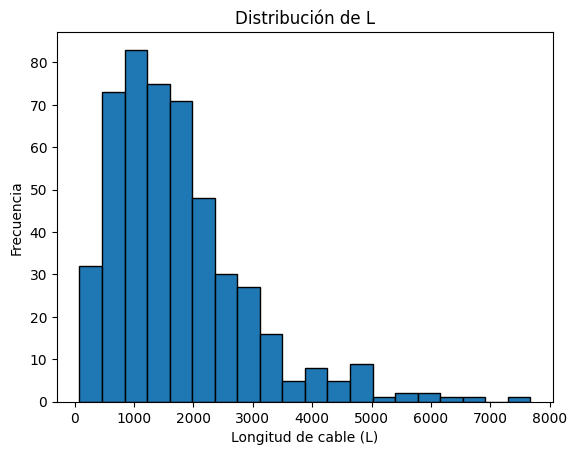

In [57]:
plt.hist(df['L'], bins=20, edgecolor='black')
plt.title("Distribución de L")
plt.xlabel("Longitud de cable (L)")
plt.ylabel("Frecuencia")
plt.show()

plt.show()

## Gráficos de dispersión

In [ ]:
# Scatter plot L vs N
plt.scatter(df['N'], df['L'], alpha=0.7)
# Línea de tendencia (regresión lineal simple)
m, b = np.polyfit(df['N'], df['L'], 1)
plt.plot(df['N'], m*df['N'] + b, color='red', linewidth=2)
plt.title("Relación L vs N")
plt.xlabel("Número de habitantes (N)")
plt.ylabel("Longitud de cable (L)")
plt.show()



In [ ]:
# Scatter plot L vs R
plt.scatter(df['R'], df['L'], alpha=0.7)
# Línea de tendencia
m, b = np.polyfit(df['R'], df['L'], 1)
plt.plot(df['R'], m*df['R'] + b, color='red', linewidth=2)
plt.title("Relación L vs R")
plt.xlabel("Radio del municipio (R)")
plt.ylabel("Longitud de cable (L)")
plt.show()

## Gráficos de dispersión separados por la media

Gráfico de L vs N

In [ ]:
# Calculamos la media
media = np.mean(df['N'])

#Separamos en municipios grandes y pequeños
dfSmall = df[df['N'] < media]
dfBig = df[df['N'] >= media]

#Gráfico de L vs N
plt.figure(figsize=(8,6))

#Municipios pequeños
plt.scatter(dfSmall['N'], dfSmall['L'], color='blue', label="Pequeños")
m,b = np.polyfit(dfSmall['N'], dfSmall['L'], 1)
plt.plot(dfSmall['N'], m*dfSmall['N'] + b, color='blue', linewidth=2)

#Municipios grandes
plt.scatter(dfBig['N'], dfBig['L'], color='orange', label="Grandes")
m,b = np.polyfit(dfBig['N'], dfBig['L'], 1)
plt.plot(dfBig['N'], m*dfBig['N'] + b, color='orange', linewidth=2)

plt.title("L vs N segmentado por tamaño de municipio")
plt.xlabel("Número de habitantes (N)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()


Gráfico de L vs R

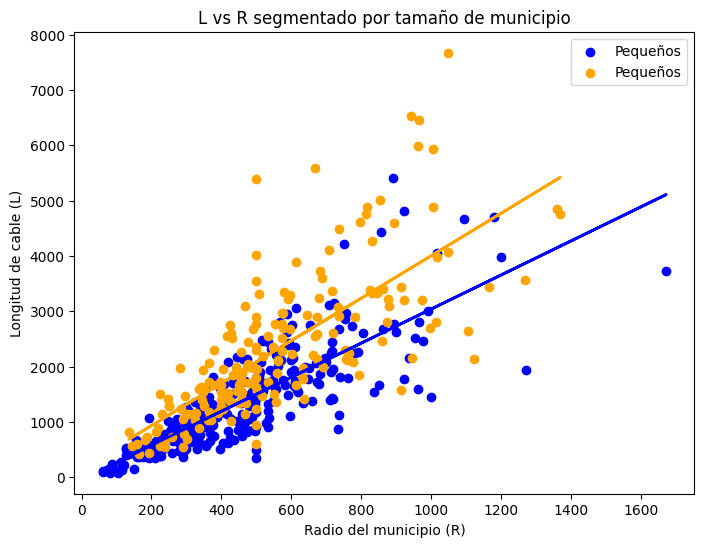

In [63]:
plt.figure(figsize=(8,6))

#Municipios pequeños
plt.scatter(dfSmall['R'], dfSmall['L'], color='blue', label="Pequeños")
m,b = np.polyfit(dfSmall['R'], dfSmall['L'], 1)
plt.plot(dfSmall['R'], m*dfSmall['R'] + b, color='blue', linewidth=2)

plt.scatter(dfBig['R'], dfBig['L'], color='orange', label="Pequeños")
m,b = np.polyfit(dfBig['R'], dfBig['L'], 1)
plt.plot(dfBig['R'], m*dfBig['R'] + b, color='orange', linewidth=2)

plt.title("L vs R segmentado por tamaño de municipio")
plt.xlabel("Radio del municipio (R)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()

### Razonamiento a incluir en el documento
Dado que los puntos en el gráfico de dispersión están distribuidos más próximos a la línea, hay una correlación mayor entre ambas variables que entre L y N, por lo que la variable R se podría decir que explica mejor los valores de la variable L

Identifiación de puntos anómalos en los gráficos de dispersión. Se usa el rango intercuartílico para detectar outliers en cada grupo

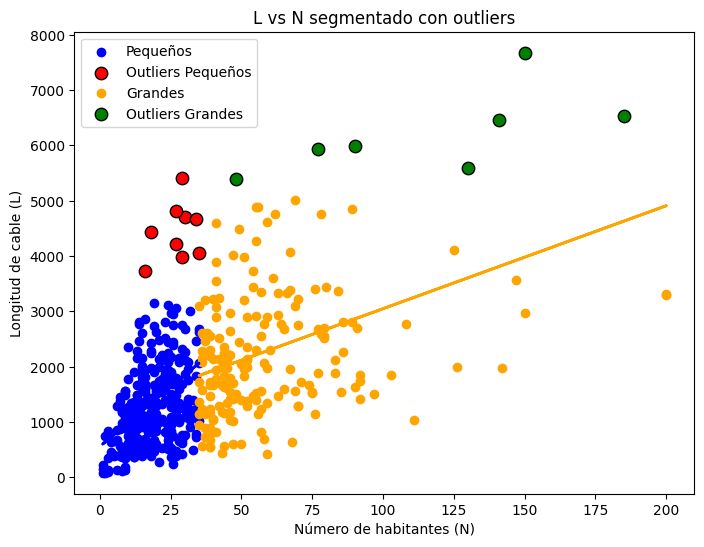

In [65]:
#Media de N
media = df['N'].mean()

dfSmall = df[df['N'] < media]   # menos habitantes que la media
dfBig = df[df['N'] >= media]  # igual o más habitantes que la media

# Función auxiliar para detectar los outliers mediante el uso de IQR
def detectar_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    # True para los outliers
    return (series < Q1 - 1.5*IQR) | (series > Q3 + 1.5*IQR)

# L vs N
plt.figure(figsize=(8,6))

# Pequeños
outliersSmall = detectar_outliers(dfSmall['L'])
plt.scatter(dfSmall['N'], dfSmall['L'], color='blue', label='Pequeños')
plt.scatter(dfSmall['N'][outliersSmall], dfSmall['L'][outliersSmall],
            color='red', edgecolor='black', s=80, label='Outliers Pequeños')  # outliers resaltados
m, b = np.polyfit(dfSmall['N'], dfSmall['L'], 1)
plt.plot(dfSmall['N'], m*dfSmall['N'] + b, color='blue', linewidth=2)

# Grandes
outliersBig = detectar_outliers(dfBig['L'])
plt.scatter(dfBig['N'], dfBig['L'], color='orange', label='Grandes')
plt.scatter(dfBig['N'][outliersBig], dfBig['L'][outliersBig],
            color='green', edgecolor='black', s=80, label='Outliers Grandes')  # outliers resaltados
m, b = np.polyfit(dfBig['N'], dfBig['L'], 1)
plt.plot(dfBig['N'], m*dfBig['N'] + b, color='orange', linewidth=2)

plt.title("L vs N segmentado con outliers")
plt.xlabel("Número de habitantes (N)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()


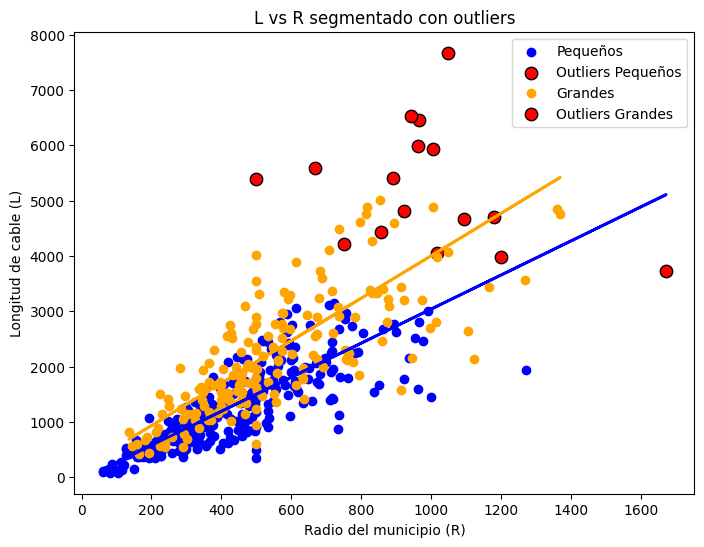

In [66]:
# 4️⃣ L vs R segmentado con outliers
plt.figure(figsize=(8,6))

# Pequeños
outliersSmall = detectar_outliers(dfSmall['L'])
plt.scatter(dfSmall['R'], dfSmall['L'], color='blue', label='Pequeños')
plt.scatter(dfSmall['R'][outliersSmall], dfSmall['L'][outliersSmall],
            color='red', edgecolor='black', s=80, label='Outliers Pequeños')
m, b = np.polyfit(dfSmall['R'], dfSmall['L'], 1)
plt.plot(dfSmall['R'], m*dfSmall['R'] + b, color='blue', linewidth=2)

# Grandes
outliersBig = detectar_outliers(dfBig['L'])
plt.scatter(dfBig['R'], dfBig['L'], color='orange', label='Grandes')
plt.scatter(dfBig['R'][outliersBig], dfBig['L'][outliersBig],
            color='red', edgecolor='black', s=80, label='Outliers Grandes')
m, b = np.polyfit(dfBig['R'], dfBig['L'], 1)
plt.plot(dfBig['R'], m*dfBig['R'] + b, color='orange', linewidth=2)

plt.title("L vs R segmentado con outliers")
plt.xlabel("Radio del municipio (R)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()